#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import ast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [188]:
df = prepare_dataframe().copy()

In [189]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [190]:
# additional_boxes = pd.read_csv(DATA_PATH + "additional_boxes_.csv", sep=";")

# additional_boxes['boxes'] = (
#     additional_boxes['x'].astype(str) + ', ' + 
#     additional_boxes['y'].astype(str) + ', ' + 
#     additional_boxes['w'].astype(str) + ', ' + 
#     additional_boxes['h'].astype(str)
# )
# additional_boxes['boxes'] = additional_boxes['boxes'].apply(lambda x: x.split(', '))
# additional_boxes.drop(['shape_0', 'shape_1', 'x', 'y', 'w', 'h'], axis=1, inplace=True)

# additional_boxes = additional_boxes.groupby('save_name').agg(list).reset_index()
# additional_boxes['label'] = additional_boxes['label'].apply(lambda x: x[0])

# additional_boxes.to_csv('../output/additional_boxes_processed.csv', index=False)

In [191]:
import ast

additional_boxes = pd.read_csv('../output/additional_boxes_processed.csv')

# process boxes
additional_boxes['boxes'] = additional_boxes['boxes'].apply(lambda x: np.array(ast.literal_eval(x)).astype(int).tolist())

# merge df
df = df.merge(additional_boxes, how='left', on='save_name', suffixes=['', '_add'])

# Remove outlier
df = df[df['label_add'] != "remove"].reset_index(drop=True)

# Merge boxes
for row in df.loc[df.boxes_add.isnull(), 'boxes_add'].index:
    df.at[row, 'boxes_add'] = []
df['boxes'] = df['boxes'] + df['boxes_add']

# Merge label
df['img_target'] = np.clip(df['img_target'] + (df['label_add'] == "opacity").astype(int), 0, 1)
df['label'] = df['img_target'].apply(lambda x: 'opacity'if x else 'none')

# Remove useless columns
df.drop(['boxes_add', 'label_add'], axis=1, inplace=True)
# df = df.dropna().reset_index()  # for debugging

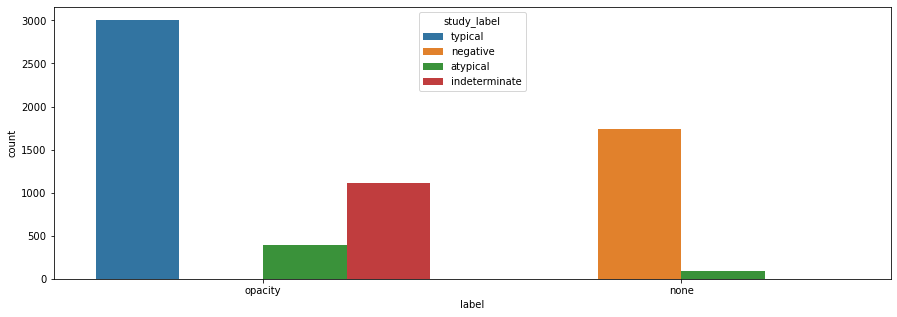

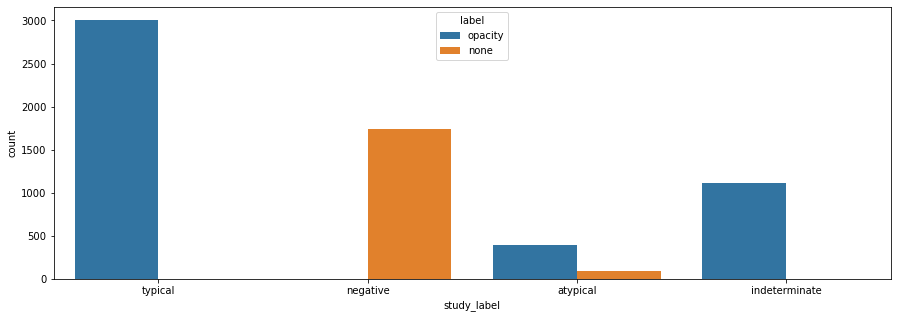

In [192]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### Dataset

In [193]:
transforms = get_transfos_det(augment=True, bbox_format="yolo")

In [194]:
dataset = CovidDetDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo") #, transforms=transforms)

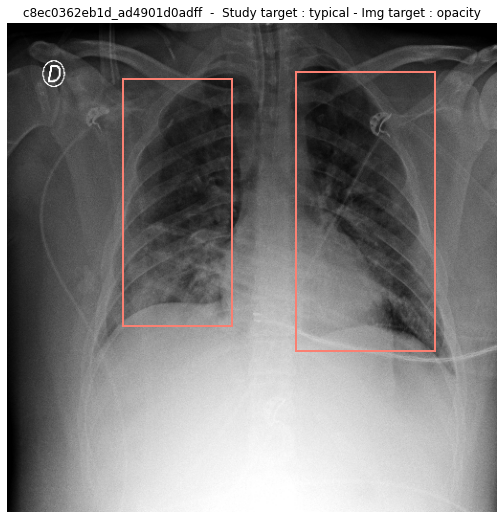

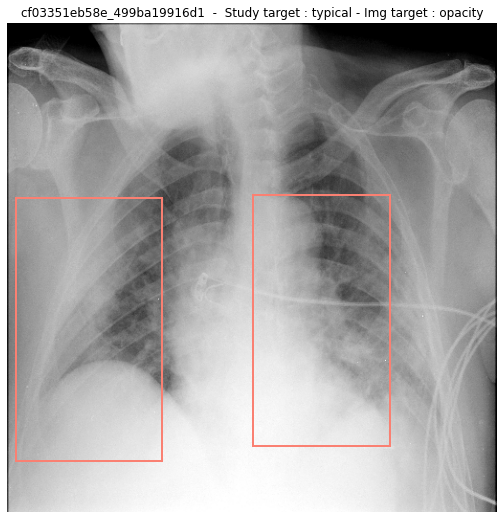

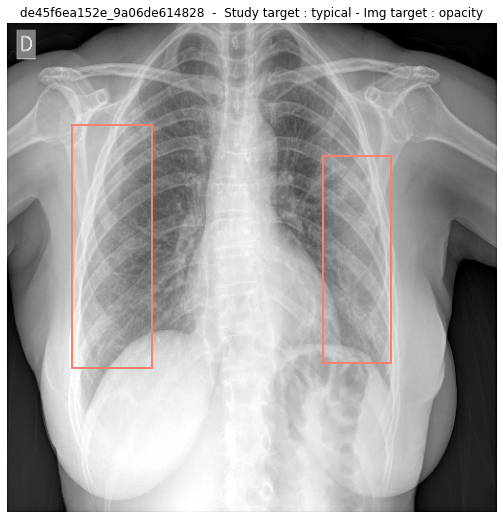

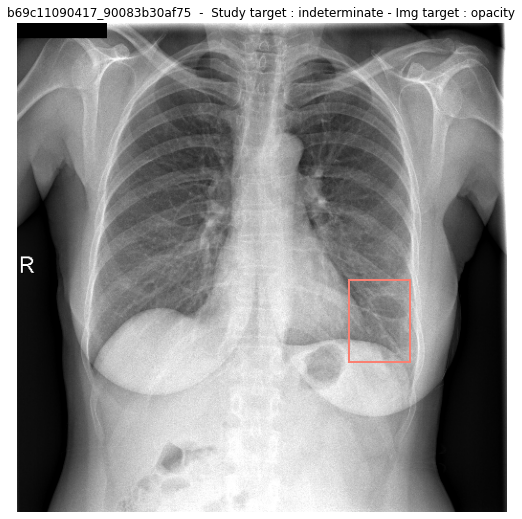

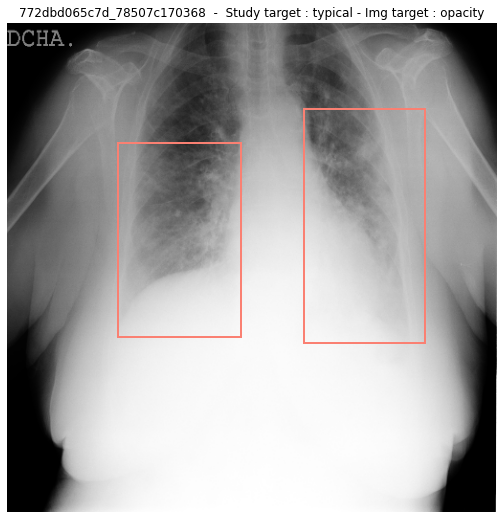

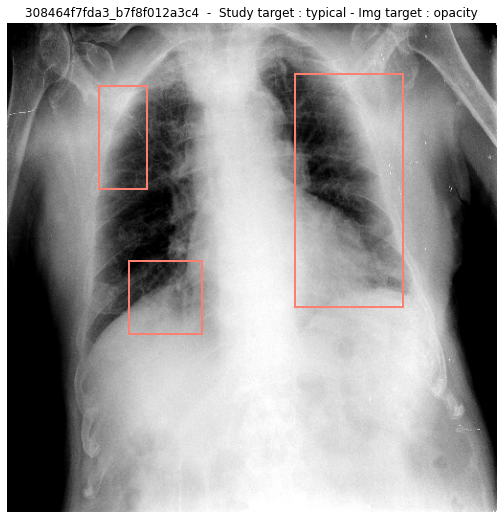

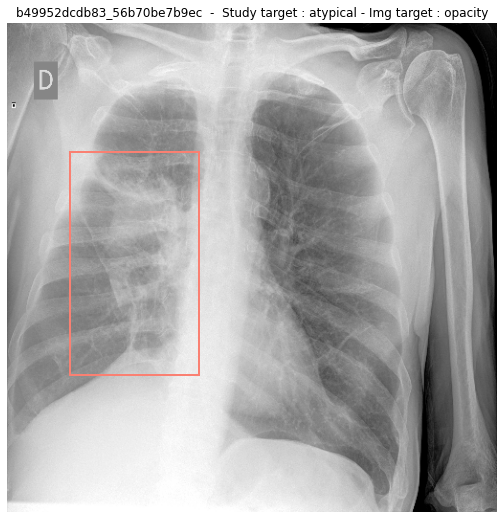

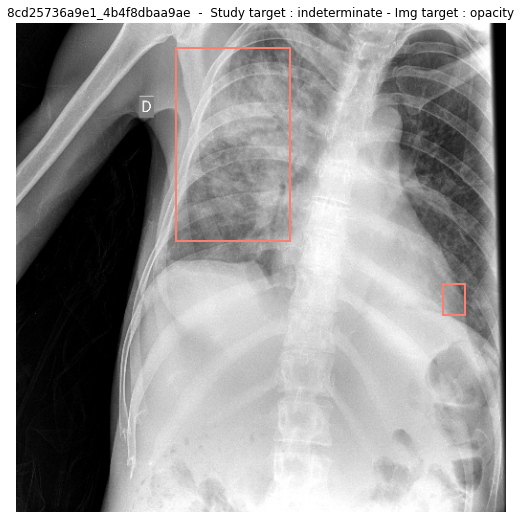

In [195]:
for i in np.random.choice(len(dataset), 10):
    img, mask, y, y_img, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if len(boxes):
        plt.figure(figsize=(9, 9))
        plot_sample(img, boxes, bbox_format="yolo")
        plt.title(
            f'{df["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
            f'Img target : {CLASSES_IMG[int(y_img)]}'
        )

## Model

In [196]:
# model = get_encoder('tf_efficientnet_b4_ns')

In [197]:
model = get_model('tf_efficientnetv2_m_in21ft1k', num_classes=4)

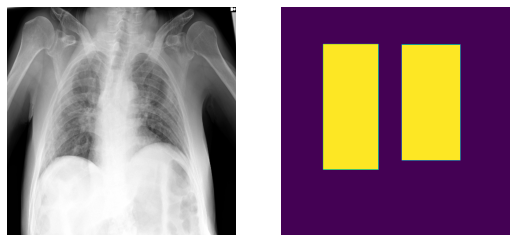

In [198]:
transforms = get_transfos_cls(augment=False)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [199]:
model.encoder.nb_fts

[48, 80, 176, 512]

In [200]:
pred = model(x)

In [201]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

torch.Size([1, 4])
torch.Size([1, 1])
  torch.Size([1, 1, 32, 32])
  torch.Size([1, 1, 16, 16])


In [202]:
from training.losses import CovidLoss
loss = CovidLoss()

In [203]:
y, pred[0]

(tensor([1.]),
 tensor([[-0.0233, -0.1329,  0.2131,  0.1807]], grad_fn=<AddmmBackward>))

In [204]:
loss = CovidLoss()
loss(pred[0], pred[1], pred[2], [y, y], y_img, m, 1)

tensor([2.6612], grad_fn=<AddBackward0>)

## Training

In [205]:
BATCH_SIZES = {
    "resnext50_32x4d": 16,
    'tf_efficientnetv2_s_in21ft1k': 16,
    'tf_efficientnetv2_m_in21ft1k': 12,
    'tf_efficientnet_b2_ns': 32,
    'tf_efficientnet_b3_ns': 16,
    'tf_efficientnet_b4_ns': 12,
    'tf_efficientnet_b5_ns': 8,
}

In [206]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    
    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'tf_efficientnetv2_m_in21ft1k'
    use_unet = False
    num_classes = len(CLASSES)

    # Training
    use_fp16 = True
    samples_per_patient = 1
    optimizer = "Adam"
    batch_size = BATCH_SIZES[selected_model]
    epochs = [10] 

    lr = [1e-3]
    warmup_prop = 0.05
    val_bs = batch_size * 2

    first_epoch_eval = 0
    
    mix = "cutmix"
    mix_proba = 0.5
    mix_alpha = 0.4

    name = "model"

In [207]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")

pred_oof_study, pred_oof_img = k_fold(
    Config,
    df,
    df_extra=None,
    log_folder=log_folder
)

Logging results to ../logs/2021-07-27/15/

-------------   Fold 1 / 5  -------------

    -> 5064 training images
    -> 1269 validation images
    -> 55231203 trainable parameters

Using 403 out of 422 batches by limiting to 1 samples per study.

Epoch 01/10 	 lr=9.5e-04	 t=182s 	loss=1.800	val_loss=1.378	 study_map=0.329	 img_map=0.949
Epoch 02/10 	 lr=8.4e-04	 t=183s 	loss=1.530	val_loss=1.405	 study_map=0.334	 img_map=0.940
Epoch 03/10 	 lr=7.4e-04	 t=184s 	loss=1.488	val_loss=1.404	 study_map=0.345	 img_map=0.945
Epoch 04/10 	 lr=6.3e-04	 t=184s 	loss=1.446	val_loss=1.358	 study_map=0.357	 img_map=0.951
Epoch 05/10 	 lr=5.3e-04	 t=184s 	loss=1.426	val_loss=1.315	 study_map=0.355	 img_map=0.957
Epoch 06/10 	 lr=4.2e-04	 t=184s 	loss=1.406	val_loss=1.301	 study_map=0.366	 img_map=0.954
Epoch 07/10 	 lr=3.2e-04	 t=185s 	loss=1.374	val_loss=1.309	 study_map=0.359	 img_map=0.954
Epoch 08/10 	 lr=2.1e-04	 t=185s 	loss=1.350	val_loss=1.262	 study_map=0.373	 img_map=0.957
Epoch 09/10 	 lr